# Quickly Analyse Stock Performance

In [16]:
import ffn 
from empyrical import alpha_beta
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import discrete_allocation
import matplotlib as pyplot
import numpy as np
import pandas as pd

%matplotlib inline

import datetime as dt
#from datetime import datetime
from datetime import datetime, timedelta 
date = dt.datetime.now()
modified_date = date - timedelta(days=1)
e_= dt.datetime.strftime(modified_date, "%Y-%m-%d")
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import warnings
plt.style.use('dark_background')
warnings.simplefilter(action='ignore', category=FutureWarning)

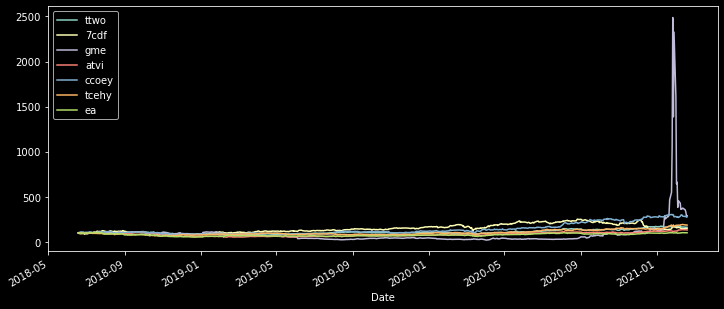

In [40]:
symbols  = ['TTWO', '7CD.F', 'GME', 'ATVI', 'CCOEY', 'TCEHY', 'EA']

prices = ffn.get('TTWO, 7CD.F, GME, ATVI, CCOEY, TCEHY, EA', start='2016-01-01')
benchmark = ffn.get('spy', start='2016-01-01')
ax = prices.rebase().plot(figsize=(12,5))

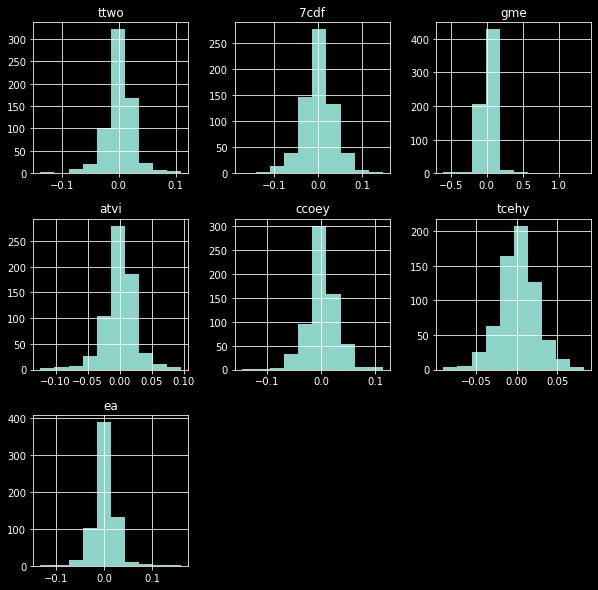

In [41]:
returns = prices.to_returns().dropna()
ax = returns.hist(figsize=(10,10))

In [37]:
stats = prices.calc_stats()

In [18]:
stats.display()

Stat                 ttwo        7cdf        gme         atvi        ccoey       tcehy       ea
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2018-06-18  2018-06-18  2018-06-18  2018-06-18  2018-06-18  2018-06-18  2018-06-18
End                  2021-02-19  2021-02-19  2021-02-19  2021-02-19  2021-02-19  2021-02-19  2021-02-19
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         61.45%      47.37%      190.56%     31.34%      178.21%     86.06%      0.89%
Daily Sharpe         0.66        0.55        0.94        0.47        1.09        0.82        0.19
Daily Sortino        1.05        0.90        2.08        0.73        1.78        1.39        0.31
CAGR                 19.61%      15.60%      49.00%      10.73%      46.60%      26.13%      0.33%
Max Drawdown         -38.67%     -48.55%     -88.32%     -51.90%     -31.85%     -37.71%     -48.5

what about the drawdowns?

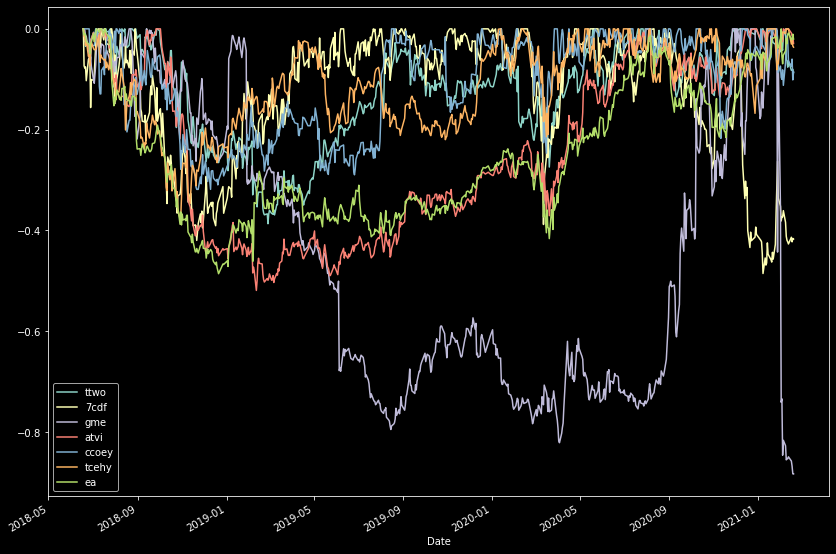

In [29]:
ax = stats.prices.to_drawdown_series().plot()

### Compound annual growth rate for a given price

In [60]:
stats.prices.calc_cagr()

ttwo     0.196134
7cdf     0.156002
gme      0.489987
atvi     0.107307
ccoey    0.465982
tcehy    0.261276
ea       0.003306
dtype: float64

### Financial Functions

Determine the proper weights using a mean-variance approach 

In [42]:
returns=prices.to_log_returns().dropna()
returns.calc_mean_var_weights().as_format('.2%')

ttwo     17.74%
7cdf      9.38%
gme      13.45%
atvi      0.00%
ccoey    37.92%
tcehy    21.51%
ea        0.00%
dtype: object

Determine the weights using a equally weighted approach

In [61]:
returns.calc_erc_weights().as_format('.2%')

ttwo     15.19%
7cdf     14.10%
gme       6.04%
atvi     15.06%
ccoey    16.97%
tcehy    16.59%
ea       16.04%
Name: erc, dtype: object

David Varadi’s Fast Threshold Clustering Algorithm (FTCA)

In [43]:
returns.calc_ftca(threshold=0.8)

{1: ['atvi'],
 2: ['gme'],
 3: ['ea'],
 4: ['7cdf'],
 5: ['tcehy'],
 6: ['ccoey'],
 7: ['ttwo']}

Calculate the beta of each stock

In [44]:
for sym in symbols:
    stk = ffn.get(sym, start='2016-01-01')
    alpha, beta = alpha_beta(stk, benchmark)
    print(sym, beta)

TTWO 0.7980826882740445
7CD.F 0.34389923434141534
GME -0.016281309619461642
ATVI 0.24730847453242202
CCOEY 0.12397979303724593
TCEHY 0.2906356576678029
EA 0.31744558028280706


# Portfolio Return & Efficient Frontier

We bought 3 stocks of TTWO, 3 stocks of 7CD.F, 5 stocks of GME, 2 stocks of ATVI, 4 stock of CCOEY, 1 stock of TCEHY and 2 EA stocks. We need to calculate the right return depending on the weights. 

In [26]:
returns = prices.pct_change()
weight = np.array([3, 3, 5, 2, 4, 1, 2])
t = np.sum(weight)
weights = weight/t 
# mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
 
# portfolio weights
#weights = np.asarray([0.4,0.2,0.1,0.1,0.1,0.1])
 
portfolio_return = round(np.sum(mean_daily_returns * weights) * 252,2)
portfolio_std_dev = round(np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252),2)

print("Expected annualised return: " + str(portfolio_return))
print("Volatility: " + str(portfolio_std_dev))

Expected annualised return: 0.61
Volatility: 0.48


### The Efficient Frontier

In [27]:
# Expected returns and sample covariance
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Optimise portfolio for maximum Sharpe Ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('ttwo', 0.13897), ('7cdf', 0.00062), ('gme', 0.04078), ('atvi', 0.0), ('ccoey', 0.55388), ('tcehy', 0.26575), ('ea', 0.0)])
Expected annual return: 38.6%
Annual volatility: 32.3%
Sharpe Ratio: 1.13


(0.3864163267780776, 0.3229147224591738, 1.134715456723729)

In [28]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
ef.efficient_return(target_return=0.2, market_neutral=True)

OrderedDict([('ttwo', 0.2445474263465108),
             ('7cdf', -0.0640838461472828),
             ('gme', 0.0267723899455772),
             ('atvi', -0.0848009156749212),
             ('ccoey', 0.2582708259287114),
             ('tcehy', 0.1277661595030677),
             ('ea', -0.5084720399016631)])